In [27]:
import cftime
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.stats import genextreme as gev
from scipy import stats
import xclim as xc
from xclim import sdba
from xclim.sdba import nbutils

from unseen import fileio
from unseen import eva
from unseen import moments
from unseen import similarity
from unseen import stability
from unseen import bias_correction
from unseen import time_utils

In [28]:
lat = {}
lon = {}

lat['Mildura'] = -34.2
lon['Mildura'] = 142.1

lat['Moree'] = -29.5
lon['Moree'] = 149.8

lat['Cape-Grim'] = -40.7
lon['Cape-Grim'] = 144.7

In [29]:
location = 'Cape-Grim'

### Observations

In [30]:
#txx_obs_file = '/g/data/xv83/unseen-projects/outputs/txx/data/txx_AGCD-CSIRO_r05_1901-2024_annual-jul-to-jun_aus.nc'
#txx_obs_file = '/Users/irv033/Desktop/txx_AGCD-CSIRO_r05_1901-2024_annual-jul-to-jun_aus.nc'
txx_obs_file = '/Users/irv033/Desktop/txx_AGCD-CSIRO_1901-2024_annual-jul-to-jun_AUS300i.nc'

In [31]:
ds_obs = fileio.open_dataset(txx_obs_file)

In [32]:
da_obs = ds_obs['tasmax'].sel({'lat': lat[location], 'lon': lon[location]}, method='nearest')

In [33]:
da_obs = da_obs.compute()

In [34]:
df_obs = da_obs.to_dataframe()

In [35]:
ranked_years = df_obs.sort_values(by='tasmax', ascending=False)
print(ranked_years.head(n=10))

                      lat    lon  event_time     tasmax
time                                                   
1995-06-30 00:00:00 -41.5  145.0  1995-02-25  31.480892
1982-06-30 00:00:00 -41.5  145.0  1982-02-15  31.439373
1973-06-30 00:00:00 -41.5  145.0  1973-01-20  31.120871
1959-06-30 00:00:00 -41.5  145.0  1959-01-17  30.812651
2009-06-30 00:00:00 -41.5  145.0  2009-01-30  30.688412
1988-06-30 00:00:00 -41.5  145.0  1988-01-29  30.628887
1977-06-30 00:00:00 -41.5  145.0  1977-02-12  30.486225
2018-06-30 00:00:00 -41.5  145.0  2018-01-28  30.310343
2013-06-30 00:00:00 -41.5  145.0  2013-01-04  30.285006
2003-06-30 00:00:00 -41.5  145.0  2003-01-25  30.227442


In [36]:
linear_fit_obs = np.polyfit(da_obs.time.dt.year.values, da_obs.values, 1)
linear_data_obs = np.polyval(linear_fit_obs, da_obs.time.dt.year.values)

In [37]:
base_mean_obs = da_obs.sel(time=slice('1972-01-01', '2018-12-31')).mean().values

In [38]:
da_obs_detrended = (da_obs - linear_data_obs) + base_mean_obs
da_obs_detrended.attrs = da_obs.attrs

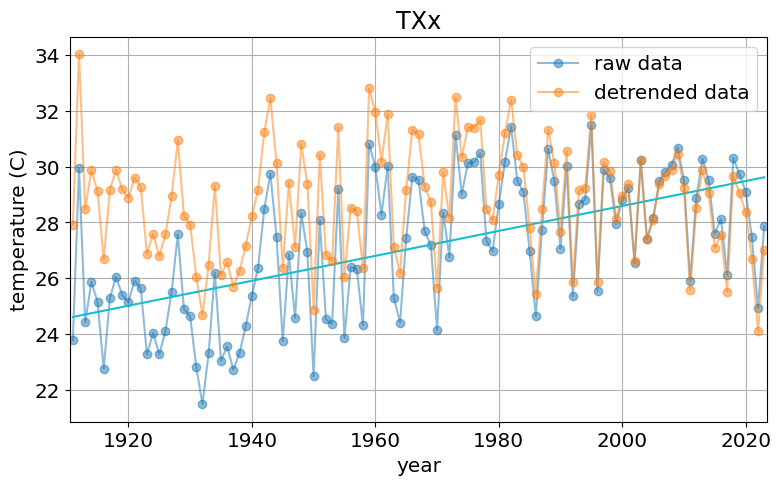

In [39]:
fig, ax = plt.subplots(figsize=[9, 5])
years = da_obs['time'].dt.year.values
plt.plot(years, da_obs.values, marker='o', label='raw data', color='tab:blue', alpha=0.5)
plt.plot(years, linear_data_obs, color='tab:cyan')
plt.plot(years, da_obs_detrended.values, marker='o', label='detrended data', color='tab:orange', alpha=0.5)
plt.xlim(years[0] - 0.5, years[-1] + 0.5)
plt.title('TXx')
plt.ylabel('temperature (C)')
plt.xlabel('year')
plt.legend()
plt.grid()

In [40]:
gev_shape_obs_detrended, gev_loc_obs_detrended, gev_scale_obs_detrended = eva.fit_gev(da_obs_detrended.values)
print(f'Shape parameter: {gev_shape_obs_detrended:.2f}')
print(f'Location parameter: {gev_loc_obs_detrended:.2f}')
print(f'Scale parameter: {gev_scale_obs_detrended:.2f}')

Shape parameter: 0.27
Location parameter: 28.03
Scale parameter: 1.99


### Model data

In [41]:
#txx_model_file = '/g/data/xv83/unseen-projects/outputs/txx/data/txx_CanESM5-dcppA-hindcast_196101-201701_annual-jul-to-jun_aus.nc'
#txx_model_file = '/Users/irv033/Desktop/txx_CanESM5-dcppA-hindcast_196101-201701_annual-jul-to-jun_aus.nc'
txx_model_file = '/Users/irv033/Desktop/txx_CanESM5-dcppA-hindcast_196101-201701_annual-jul-to-jun_AUS300i.nc'

In [42]:
ds_model = fileio.open_dataset(txx_model_file)

In [43]:
da_model = ds_model['tasmax'].sel({'lat': lat[location], 'lon': lon[location]}, method='nearest')

In [44]:
da_model = da_model.compute()

In [45]:
da_model_stacked = da_model.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [46]:
linear_fit_model = np.polyfit(da_model_stacked.time.dt.year.values, da_model_stacked.values, 1)
linear_data_model = np.polyval(linear_fit_model, np.unique(da_model_stacked.time.dt.year.values))

In [47]:
da_model_stacked_base = time_utils.select_time_period(da_model_stacked.copy(), ['1972-01-01', '2018-12-31'])
base_mean_model = da_model_stacked_base.mean().values

In [48]:
value_year_pairs = np.column_stack((da_model_stacked.values, da_model_stacked.time.dt.year.values))
detrended_data = []
for value, year in value_year_pairs:
    af = np.polyval(linear_fit_model, year)
    detrended_value = value - af + base_mean_model
    detrended_data.append(detrended_value)
detrended_data = np.array(detrended_data)

In [49]:
da_model_detrended_stacked = da_model_stacked * 0 + detrended_data
da_model_detrended_stacked.attrs = da_model_stacked.attrs

In [50]:
da_model_detrended = da_model_detrended_stacked.unstack()

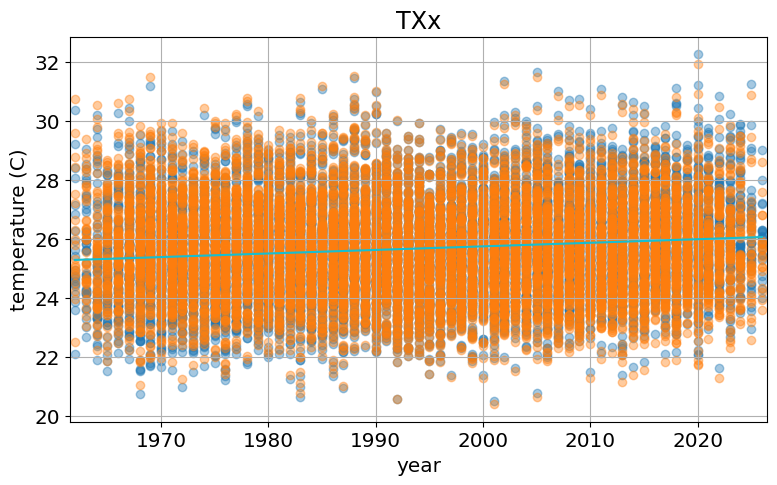

In [51]:
fig, ax = plt.subplots(figsize=[9, 5])
years = da_model_stacked['time'].dt.year.values
unique_years = np.unique(da_model_stacked.time.dt.year.values)
plt.scatter(years, da_model_stacked.values, marker='o', color='tab:blue', alpha=0.4, label='raw data')
plt.plot(unique_years, linear_data_model, color='tab:cyan')
plt.scatter(years, da_model_detrended_stacked.values, marker='o', color='tab:orange', alpha=0.4, label='detrended data')
plt.xlim(unique_years[0] - 0.5, unique_years[-1] + 0.5)
plt.title('TXx')
plt.ylabel('temperature (C)')
plt.xlabel('year')
#plt.legend()
plt.grid()

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


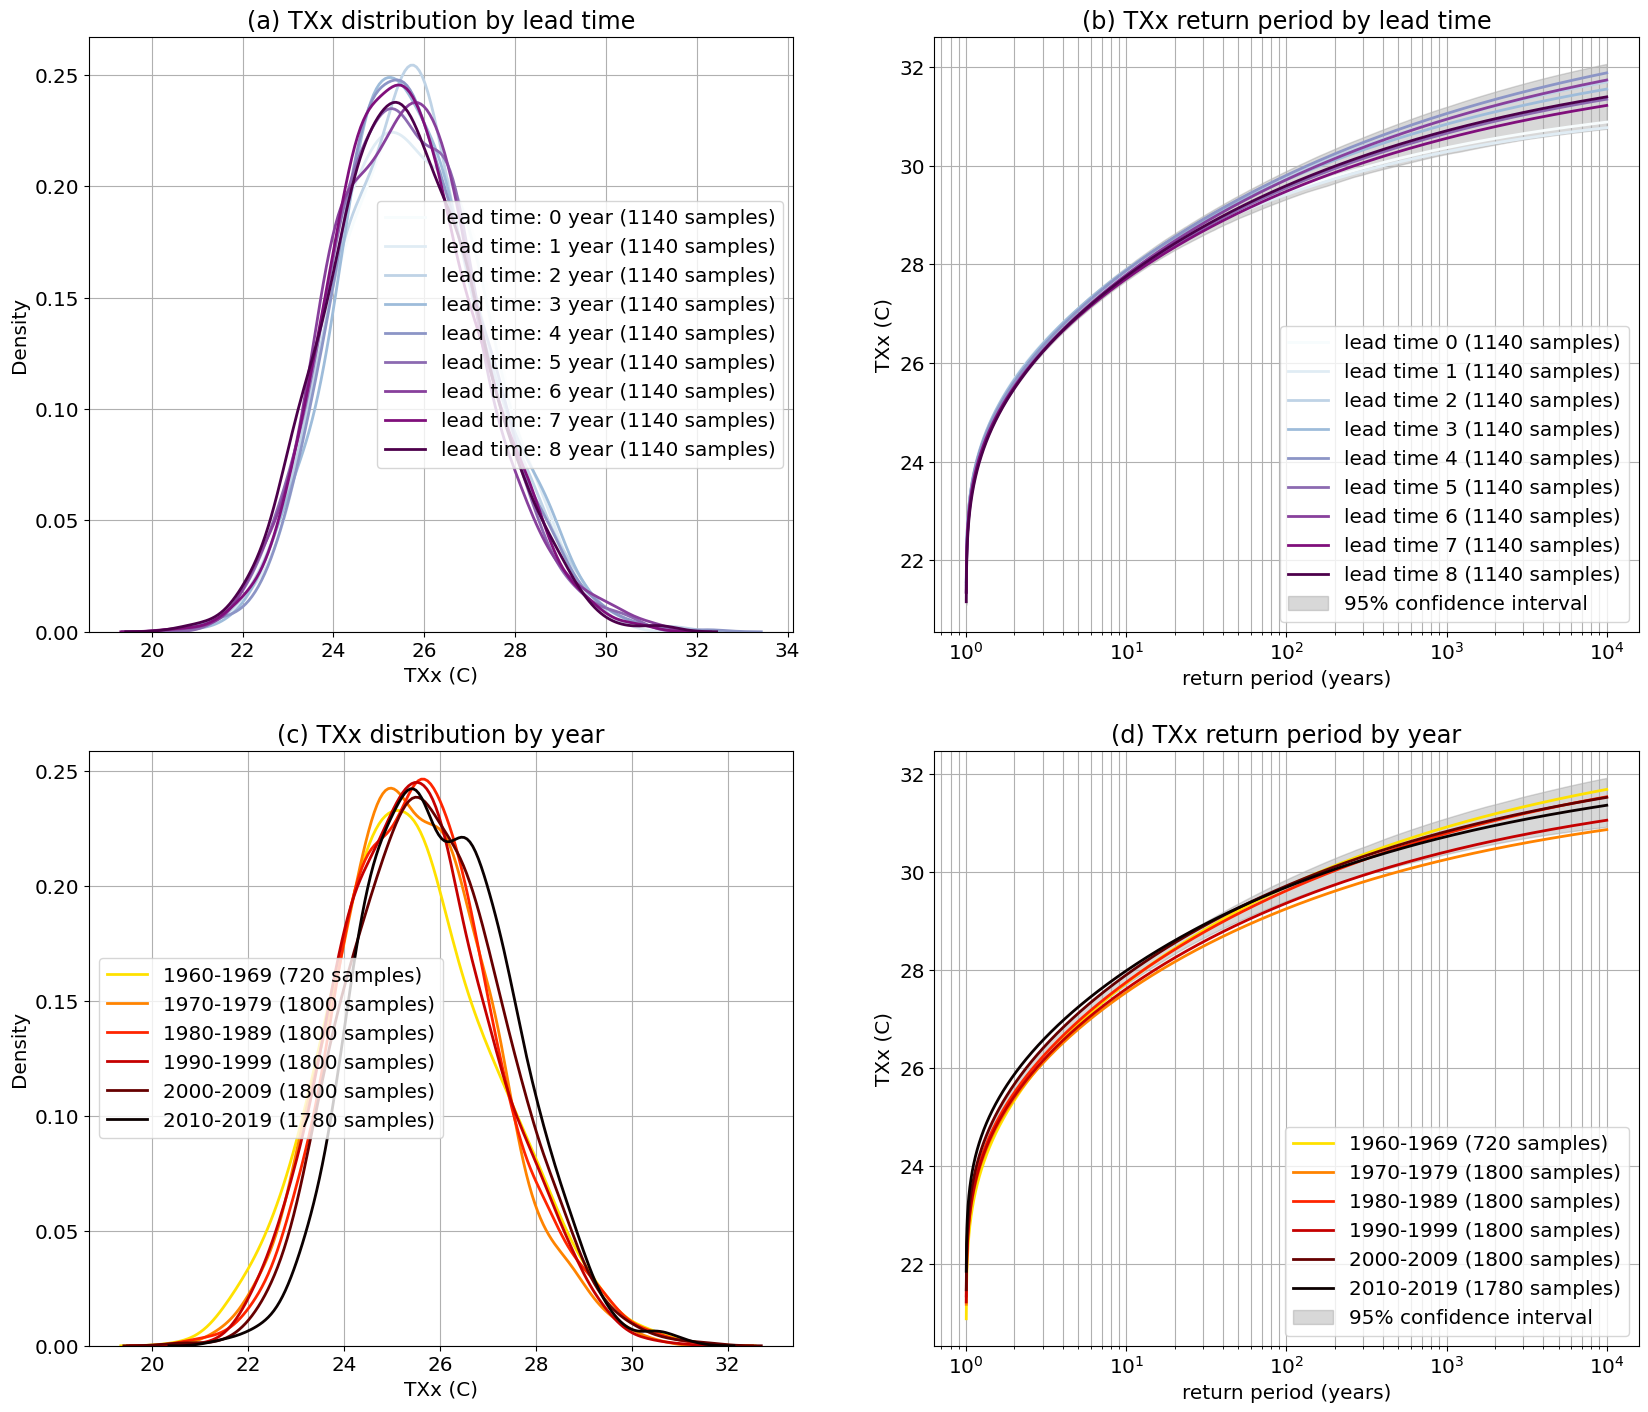

In [52]:
stability.create_plot(
    da_model,
    'TXx',
    [1960, 1970, 1980, 1990, 2000, 2010],
    uncertainty=True,
    return_method='gev',
    units='TXx (C)',
#    ylim=(0, 450),
)

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


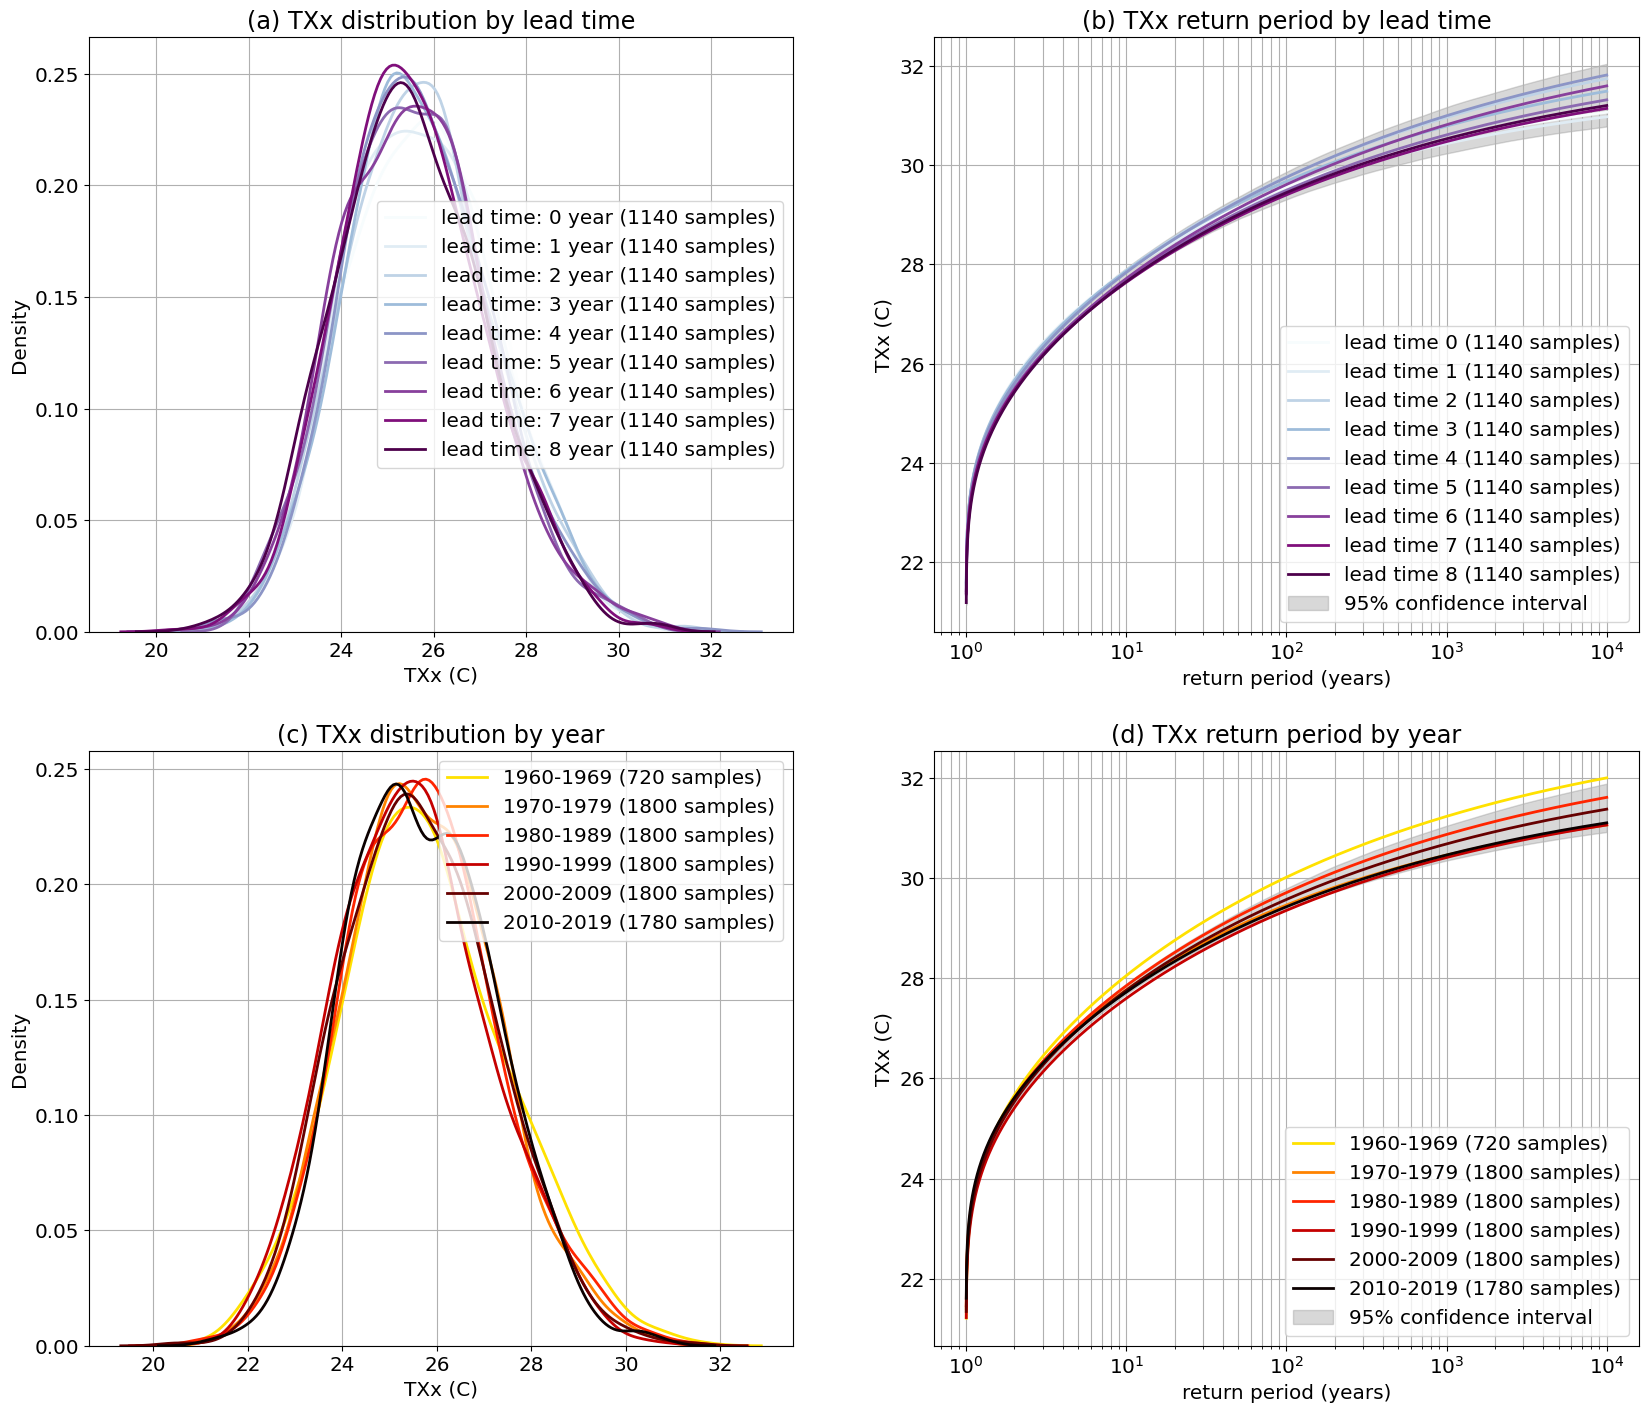

In [53]:
stability.create_plot(
    da_model_detrended,
    'TXx',
    [1960, 1970, 1980, 1990, 2000, 2010],
    uncertainty=True,
    return_method='gev',
    units='TXx (C)',
#    ylim=(0, 450),
)

In [54]:
gev_shape_model_detrended, gev_loc_model_detrended, gev_scale_model_detrended = eva.fit_gev(da_model_detrended_stacked.values)
print(f'Shape parameter: {gev_shape_model_detrended:.2f}')
print(f'Location parameter: {gev_loc_model_detrended:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended:.2f}')

Shape parameter: 0.20
Location parameter: 25.03
Scale parameter: 1.52


### Mean correction

#### Additive

In [55]:
bias_mean_add = bias_correction.get_bias(
    da_model_detrended,
    da_obs_detrended,
    'additive',
    time_rounding='A',
    time_period=['1972-01-01', '2018-12-31']
)

In [56]:
da_model_detrended_bc_mean_add = bias_correction.remove_bias(da_model_detrended, bias_mean_add, 'additive')

In [57]:
da_model_detrended_bc_mean_add = da_model_detrended_bc_mean_add.compute()

In [58]:
da_model_detrended_bc_mean_add_stacked = da_model_detrended_bc_mean_add.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [59]:
gev_shape_model_detrended_bc_mean_add, gev_loc_model_detrended_bc_mean_add, gev_scale_model_detrended_bc_mean_add = eva.fit_gev(da_model_detrended_bc_mean_add_stacked.values)
print(f'Shape parameter: {gev_shape_model_detrended_bc_mean_add:.2f}')
print(f'Location parameter: {gev_loc_model_detrended_bc_mean_add:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended_bc_mean_add:.2f}')

Shape parameter: 0.20
Location parameter: 28.54
Scale parameter: 1.52


#### Multiplicative

In [60]:
bias_mean_mulc = bias_correction.get_bias(
    da_model_detrended,
    da_obs_detrended,
    'multiplicative',
    time_rounding='A',
    time_period=['1972-01-01', '2018-12-31']
)

In [61]:
da_model_detrended_bc_mean_mulc = bias_correction.remove_bias(da_model_detrended, bias_mean_mulc, 'additive')
da_model_detrended_bc_mean_mulc = da_model_detrended_bc_mean_mulc.compute()

In [62]:
da_model_detrended_bc_mean_mulc_stacked = da_model_detrended_bc_mean_mulc.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [63]:
gev_shape_model_detrended_bc_mean_mulc, gev_loc_model_detrended_bc_mean_mulc, gev_scale_model_detrended_bc_mean_mulc = eva.fit_gev(da_model_detrended_bc_mean_mulc_stacked.values)
print(f'Shape parameter: {gev_shape_model_detrended_bc_mean_mulc:.2f}')
print(f'Location parameter: {gev_loc_model_detrended_bc_mean_mulc:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended_bc_mean_mulc:.2f}')

Shape parameter: 0.20
Location parameter: 24.15
Scale parameter: 1.52


### Quantile correction

In [64]:
nquantiles = 10
quantile_array = xc.sdba.utils.equally_spaced_nodes(nquantiles)

In [65]:
quantile_array

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

In [66]:
da_model_detrended_q = nbutils.quantile(
    da_model_detrended_stacked,
    quantile_array,
    ['sample']
)

# time_utils.select_time_period(da_model_stacked.copy(), ['1972-01-01', '2018-12-31'])

In [67]:
da_model_detrended_q.values

array([23.16902467, 24.00328383, 24.5219812 , 24.97047707, 25.37421925,
       25.79139787, 26.21787911, 26.69626796, 27.32079904, 28.38714407])

In [68]:
da_obs_detrended_q = nbutils.quantile(
    da_obs_detrended,
    quantile_array,
    ['time']
)

# time_utils.select_time_period(da_obs.copy(), ['1972-01-01', '2018-12-31']),

In [69]:
da_obs_detrended_q.values

array([25.62444106, 26.45827283, 27.11010703, 28.08249769, 28.51799387,
       29.17349897, 29.57264043, 30.13668972, 30.99882459, 31.90827914])

In [70]:
bias_quantile_add = da_model_detrended_q.values - da_obs_detrended_q.values

In [71]:
bias_quantile_add_cubic_fit = np.polyfit(quantile_array, bias_quantile_add, 3)

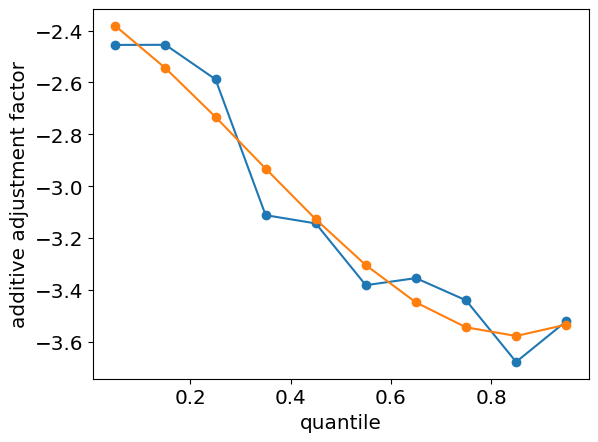

In [72]:
plt.plot(quantile_array, bias_quantile_add, marker='o')
cubic_data = np.polyval(bias_quantile_add_cubic_fit, quantile_array)
plt.plot(quantile_array, cubic_data, marker='o')
plt.xlabel('quantile')
plt.ylabel('additive adjustment factor')
plt.show()

In [73]:
bias_quantile_mulc = da_model_detrended_q.values / da_obs_detrended_q.values

In [74]:
bias_quantile_mulc_cubic_fit = np.polyfit(quantile_array, bias_quantile_mulc, 3)

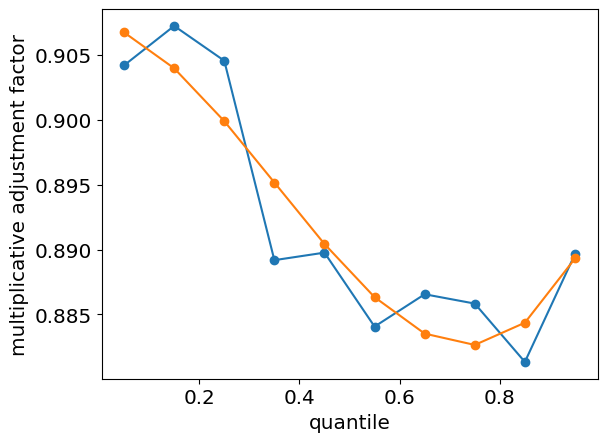

In [75]:
plt.plot(quantile_array, bias_quantile_mulc, marker='o')
cubic_data = np.polyval(bias_quantile_mulc_cubic_fit, quantile_array)
plt.plot(quantile_array, cubic_data, marker='o')
plt.xlabel('quantile')
plt.ylabel('multiplicative adjustment factor')
plt.show()

In [76]:
#def get_adjustment_factor(value, quantiles, adjustment_factors):
#    """Find the adjustment factor corresponding to the closest quantile."""
#
#    assert quantiles.shape == adjustment_factors.shape
#    
#    difference_array = np.absolute(quantiles - value)
#    index = difference_array.argmin()
#    adjustment_factor = adjustment_factors[index]
#
#    return adjustment_factor
#
#vget_adjustment_factor = np.vectorize(get_adjustment_factor, excluded=['quantiles', 'adjustment_factors'])


def get_smooth_adjustment_factor(value, data, af_cubic_fit):
    """Find the adjustment factor."""

    quantile = stats.percentileofscore(data, value) / 100
    af = np.polyval(af_cubic_fit, quantile)

    return af

vget_smooth_adjustment_factor = np.vectorize(get_smooth_adjustment_factor, excluded=['data', 'af_cubic_fit'])

#### Additive

In [77]:
#af_add = vget_adjustment_factor(
#    da_model_stacked.values,
#    quantiles=da_model_q.values,
#    adjustment_factors=bias_quantile_add,
#)
af_add = vget_smooth_adjustment_factor(
    da_model_detrended_stacked.values,
    data=da_model_detrended_stacked.values,
    af_cubic_fit=bias_quantile_add_cubic_fit,
)

In [78]:
da_model_detrended_bc_quantile_add = da_model_detrended_stacked - af_add

In [79]:
gev_shape_model_detrended_bc_quantile_add, gev_loc_model_detrended_bc_quantile_add, gev_scale_model_detrended_bc_quantile_add = eva.fit_gev(da_model_detrended_bc_quantile_add.values)
print(f'Shape parameter: {gev_shape_model_detrended_bc_quantile_add:.2f}')
print(f'Location parameter: {gev_loc_model_detrended_bc_quantile_add:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended_bc_quantile_add:.2f}')

Shape parameter: 0.26
Location parameter: 28.04
Scale parameter: 1.96


#### Multiplicative

In [80]:
#af_mulc = vget_adjustment_factor(
#    da_model_stacked.values,
#    quantiles=da_model_q.values,
#    adjustment_factors=bias_quantile_mulc,
#)
af_mulc = vget_smooth_adjustment_factor(
    da_model_detrended_stacked.values,
    data=da_model_detrended_stacked.values,
    af_cubic_fit=bias_quantile_mulc_cubic_fit,
)

In [81]:
da_model_detrended_bc_quantile_mulc = da_model_detrended_stacked / af_mulc

In [82]:
gev_shape_model_detrended_bc_quantile_mulc, gev_loc_model_detrended_bc_quantile_mulc, gev_scale_model_detrended_bc_quantile_mulc = eva.fit_gev(da_model_detrended_bc_quantile_mulc.values)
print(f'Shape parameter: {gev_shape_model_detrended_bc_quantile_mulc:.2f}')
print(f'Location parameter: {gev_loc_model_detrended_bc_quantile_mulc:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended_bc_quantile_mulc:.2f}')

Shape parameter: 0.25
Location parameter: 28.03
Scale parameter: 1.96


## Comparison

In [83]:
def fidelity_tests(da_target):
    """Perform fidelity tests."""
    
    similarity_scores = similarity.similarity_tests(da_target, da_obs)
    print('KS score:', similarity_scores['ks_statistic'].values)
    print('KS p-value:', similarity_scores['ks_pval'].values)
    print('AD score:', similarity_scores['ad_statistic'].values)
    print('AD p-value:', similarity_scores['ad_pval'].values)

    moments.create_plot(
        da_model_detrended,
        da_obs_detrended,
        da_bc_fcst=da_target,
    )

In [84]:
xmax = np.max([da_model_detrended_stacked.values.max(), da_obs_detrended.values.max()]) + 1
xmin = np.min([da_model_detrended_stacked.values.min(), da_obs_detrended.values.min()]) - 1

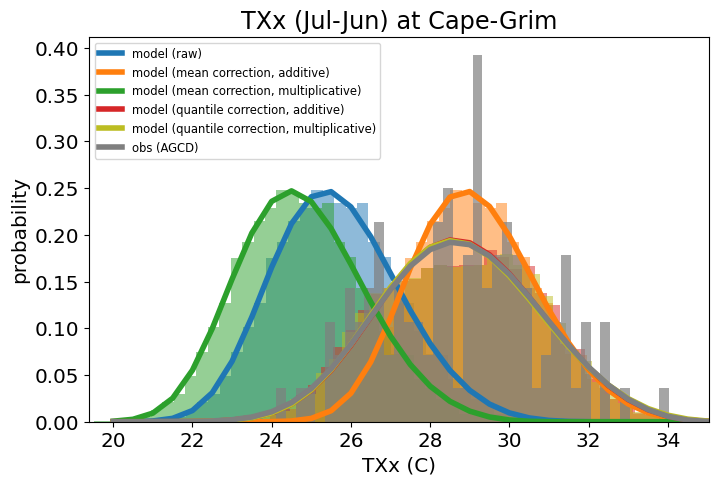

In [85]:
fig, ax = plt.subplots(figsize=[8, 5])
gev_xvals = np.arange(20, 65, 0.5)

da_model_detrended_stacked.plot.hist(bins=40, density=True, color='tab:blue', alpha=0.5)
gev_pdf_model_detrended = gev.pdf(gev_xvals, gev_shape_model_detrended, gev_loc_model_detrended, gev_scale_model_detrended)
plt.plot(gev_xvals, gev_pdf_model_detrended, color='tab:blue', linewidth=4.0, label='model (raw)')

da_model_detrended_bc_mean_add_stacked.plot.hist(bins=40, density=True, color='tab:orange', alpha=0.5)
gev_pdf_model_detrended_bc_mean_add = gev.pdf(
    gev_xvals,
    gev_shape_model_detrended_bc_mean_add,
    gev_loc_model_detrended_bc_mean_add,
    gev_scale_model_detrended_bc_mean_add
)
plt.plot(
    gev_xvals,
    gev_pdf_model_detrended_bc_mean_add,
    color='tab:orange',
    linewidth=4.0,
    label='model (mean correction, additive)'
)

da_model_detrended_bc_mean_mulc_stacked.plot.hist(bins=40, density=True, color='tab:green', alpha=0.5)
gev_pdf_model_detrended_bc_mean_mulc = gev.pdf(
    gev_xvals,
    gev_shape_model_detrended_bc_mean_mulc,
    gev_loc_model_detrended_bc_mean_mulc,
    gev_scale_model_detrended_bc_mean_mulc
)
plt.plot(
    gev_xvals,
    gev_pdf_model_detrended_bc_mean_mulc,
    color='tab:green',
    linewidth=4.0,
    label='model (mean correction, multiplicative)'
)

da_model_detrended_bc_quantile_add.plot.hist(bins=40, density=True, color='tab:red', alpha=0.5)
gev_pdf_model_detrended_bc_quantile_add = gev.pdf(
    gev_xvals,
    gev_shape_model_detrended_bc_quantile_add,
    gev_loc_model_detrended_bc_quantile_add,
    gev_scale_model_detrended_bc_quantile_add
)
plt.plot(
    gev_xvals,
    gev_pdf_model_detrended_bc_quantile_add,
    color='tab:red',
    linewidth=4.0,
    label='model (quantile correction, additive)'
)

da_model_detrended_bc_quantile_mulc.plot.hist(bins=40, density=True, color='tab:olive', alpha=0.5)
gev_pdf_model_detrended_bc_quantile_mulc = gev.pdf(
    gev_xvals,
    gev_shape_model_detrended_bc_quantile_mulc,
    gev_loc_model_detrended_bc_quantile_mulc,
    gev_scale_model_detrended_bc_quantile_mulc
)
plt.plot(
    gev_xvals,
    gev_pdf_model_detrended_bc_quantile_mulc,
    color='tab:olive',
    linewidth=4.0,
    label='model (quantile correction, multiplicative)'
)

da_obs_detrended.plot.hist(bins=40, density=True, color='tab:gray', alpha=0.7)
gev_pdf_obs_detrended = gev.pdf(gev_xvals, gev_shape_obs_detrended, gev_loc_obs_detrended, gev_scale_obs_detrended)
plt.plot(gev_xvals, gev_pdf_obs_detrended, color='tab:gray', linewidth=4.0, label='obs (AGCD)')

plt.xlabel('TXx (C)')
plt.ylabel('probability')
plt.title(f'TXx (Jul-Jun) at {location}')

plt.xlim(xmin, xmax)
plt.legend(fontsize='small')
plt.savefig(f'txx_{location}_gevs.png', bbox_inches='tight', facecolor='white')
plt.show()

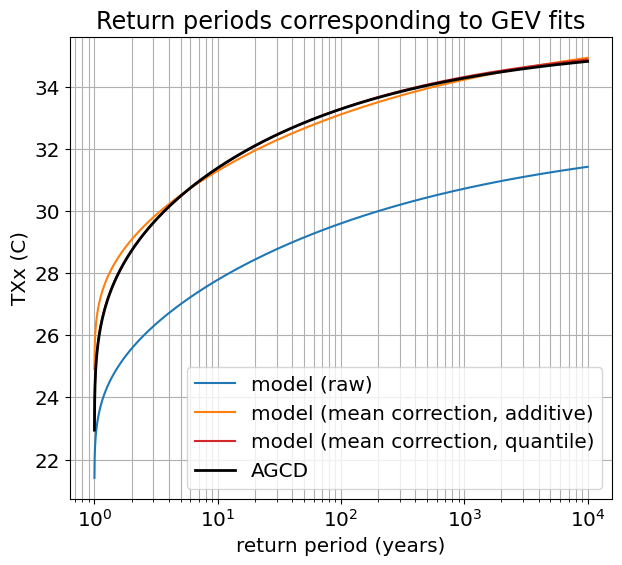

In [86]:
fig = plt.figure(figsize=[7, 6])
#ax1 = fig.add_subplot(211)
#ax2 = fig.add_subplot(212)
ax2 = fig.add_subplot(111)

#ax1.plot(gev_xvals, gev_pdf_model_detrended, color='tab:blue', label='model (raw)')
return_periods_model_detrended, return_values_model_detrended = stability.return_curve(
    da_model_detrended,
    'gev',
    params=[gev_shape_model_detrended, gev_loc_model_detrended, gev_scale_model_detrended],
)
ax2.plot(return_periods_model_detrended, return_values_model_detrended, label='model (raw)', color='tab:blue')

#ax1.plot(gev_xvals, gev_pdf_model_detrended_bc_mean_add, color='tab:orange', label='model (mean correction, additive)')
return_periods_model_detrended_bc_mean_add, return_values_model_detrended_bc_mean_add = stability.return_curve(
    da_model_detrended_bc_mean_add,
    'gev',
    params=[gev_shape_model_detrended_bc_mean_add, gev_loc_model_detrended_bc_mean_add, gev_scale_model_detrended_bc_mean_add],
)
ax2.plot(return_periods_model_detrended_bc_mean_add, return_values_model_detrended_bc_mean_add, label='model (mean correction, additive)', color='tab:orange')

#ax1.plot(gev_xvals, gev_pdf_model_detrended_bc_quantile_add, color='tab:red', label='model (quantile correction, additive)')
return_periods_model_detrended_bc_quantile_add, return_values_model_detrended_bc_quantile_add = stability.return_curve(
    da_model_detrended_bc_quantile_add,
    'gev',
    params=[gev_shape_model_detrended_bc_quantile_add, gev_loc_model_detrended_bc_quantile_add, gev_scale_model_detrended_bc_quantile_add],
)
ax2.plot(return_periods_model_detrended_bc_quantile_add, return_values_model_detrended_bc_quantile_add, label='model (mean correction, quantile)', color='tab:red')

#ax1.plot(gev_xvals, gev_pdf_obs_detrended, color='black', linewidth=2.0, label='AGCD')
return_periods_obs_detrended, return_values_obs_detrended = stability.return_curve(
    da_obs_detrended,
    'gev',
    params=[gev_shape_obs_detrended, gev_loc_obs_detrended, gev_scale_obs_detrended],
)
ax2.plot(return_periods_obs_detrended, return_values_obs_detrended, label='AGCD', color='black', linewidth=2.0)

#ax1.grid()
#ax1.set_xlabel('TXx (C)')
#ax1.set_ylabel('probability')
#ax1.axvline(agcd_max, color='0.5', linestyle='--')
#ax1.set_title('(a) GEV fit to data')
#ax1.set_xlim([0, 450])
#ax1.legend()

ax2.legend()
#ax2.axhline(agcd_max, color='0.5', linestyle='--')
ax2.set_xscale('log')
ax2.set_xlabel('return period (years)')
ax2.set_ylabel('TXx (C)')
ax2.set_title('Return periods corresponding to GEV fits')
#ax2.set_ylim([0, 700])
ax2.grid(which='both')
plt.savefig(f'txx_{location}_return_curves.png', bbox_inches='tight', facecolor='white')
plt.show()

### Raw data

In [87]:
similarity_ds = similarity.similarity_tests(da_model_detrended, da_obs_detrended)
print('KS score:', similarity_ds['ks_statistic'].values)
print('KS p-value:', similarity_ds['ks_pval'].values)
print('AD score:', similarity_ds['ad_statistic'].values)
print('AD p-value:', similarity_ds['ad_pval'].values)

KS score: 0.59790576
KS p-value: 8.729787e-39
AD score: 209.98866
AD p-value: 0.001


### Additive - mean correction

KS score: 0.39154118
KS p-value: 5.575179e-16
AD score: 104.292946
AD p-value: 0.001


INFO:root:mean: Obs = 28.752838134765575, Model 95% CI =25.363823208171056 to 25.93613240688138
INFO:root:standard deviation: Obs = 2.010321314529908, Model 95% CI =1.37801453031384 to 1.7860141612730294
INFO:root:skew: Obs = 0.026002267969428786, Model 95% CI =-0.21749264254336842 to 0.6256381063598027
INFO:root:kurtosis: Obs = -0.5198032676375743, Model 95% CI =-0.733928211081863 to 0.8239149552111238
INFO:root:GEV shape: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(0.26822544)
Coordinates:
    lat      float64 8B -41.5
    lon      float64 8B 145.0
    dparams  <U5 20B 'c'
Attributes:
    long_name:    Genextreme parameters
    description:  Parameters of the genextreme distribution
    method:       MLE
    estimator:    LMM
    scipy_dist:   genextreme
    units:        , Model 95% CI =0.0880169370396599 to 0.3655698997938949
INFO:root:GEV location: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(28.0275991)
Coordinates:
    lat      float64 8B -41.5
    lon      float6

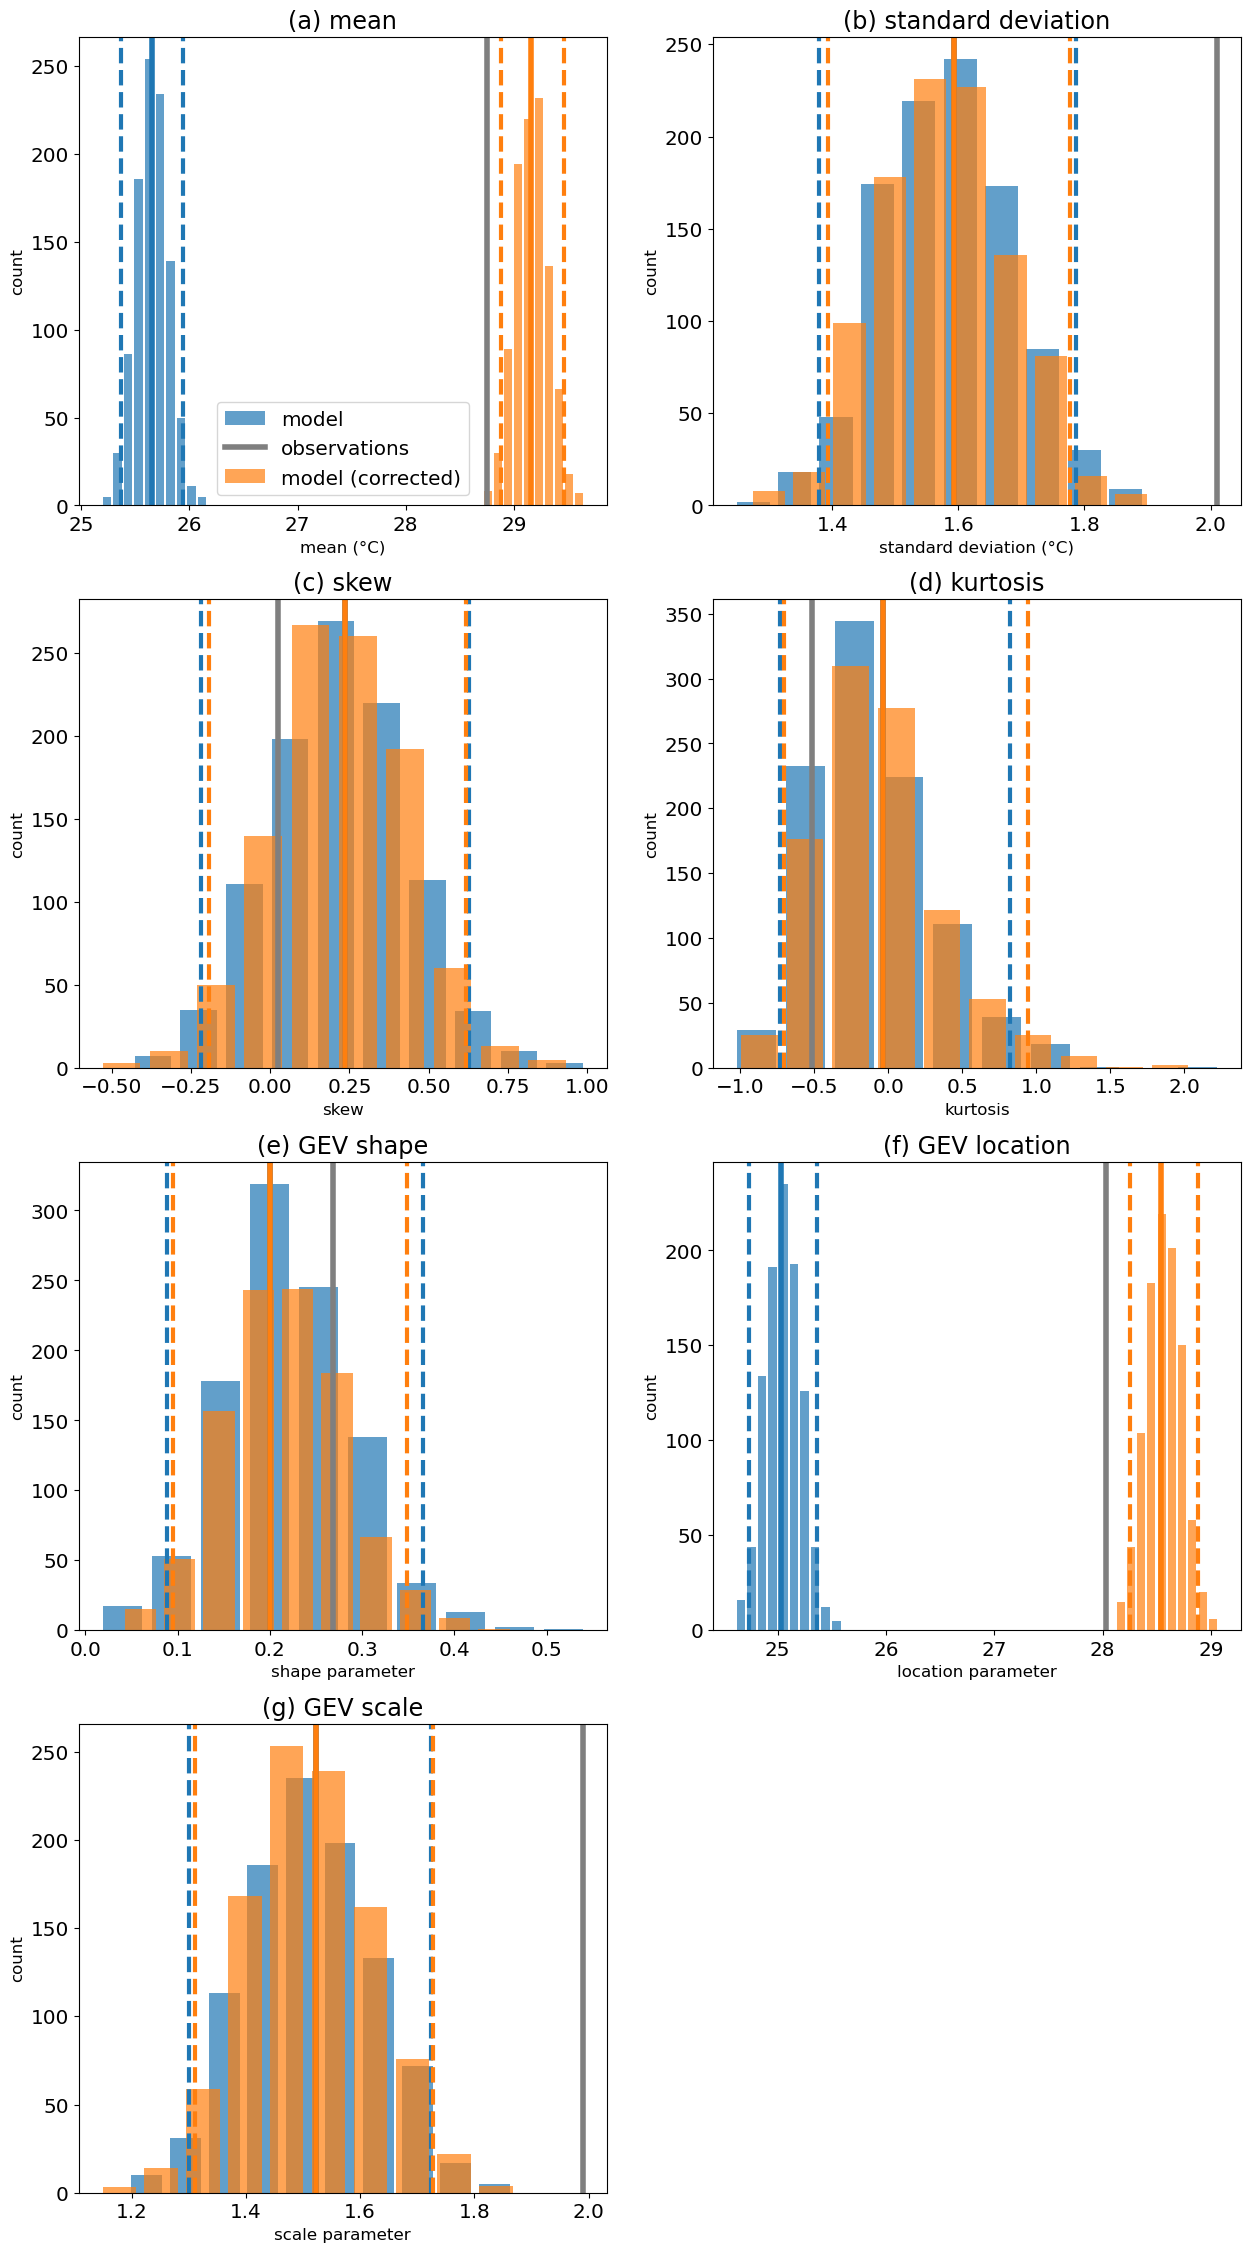

In [88]:
fidelity_tests(da_model_detrended_bc_mean_add)

### Multiplicative - mean correction

KS score: 0.4659818
KS p-value: 8.355564e-23
AD score: 125.68522
AD p-value: 0.001


INFO:root:mean: Obs = 28.752838134765575, Model 95% CI =25.345372462526406 to 25.943378362987648
INFO:root:standard deviation: Obs = 2.010321314529908, Model 95% CI =1.3953172983306716 to 1.7993062991534692
INFO:root:skew: Obs = 0.026002267969428786, Model 95% CI =-0.19619169439491535 to 0.6223277739333082
INFO:root:kurtosis: Obs = -0.5198032676375743, Model 95% CI =-0.7154052569654455 to 0.8987943052797416
INFO:root:GEV shape: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(0.26822544)
Coordinates:
    lat      float64 8B -41.5
    lon      float64 8B 145.0
    dparams  <U5 20B 'c'
Attributes:
    long_name:    Genextreme parameters
    description:  Parameters of the genextreme distribution
    method:       MLE
    estimator:    LMM
    scipy_dist:   genextreme
    units:        , Model 95% CI =0.08834343755286828 to 0.3446520095590264
INFO:root:GEV location: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(28.0275991)
Coordinates:
    lat      float64 8B -41.5
    lon      f

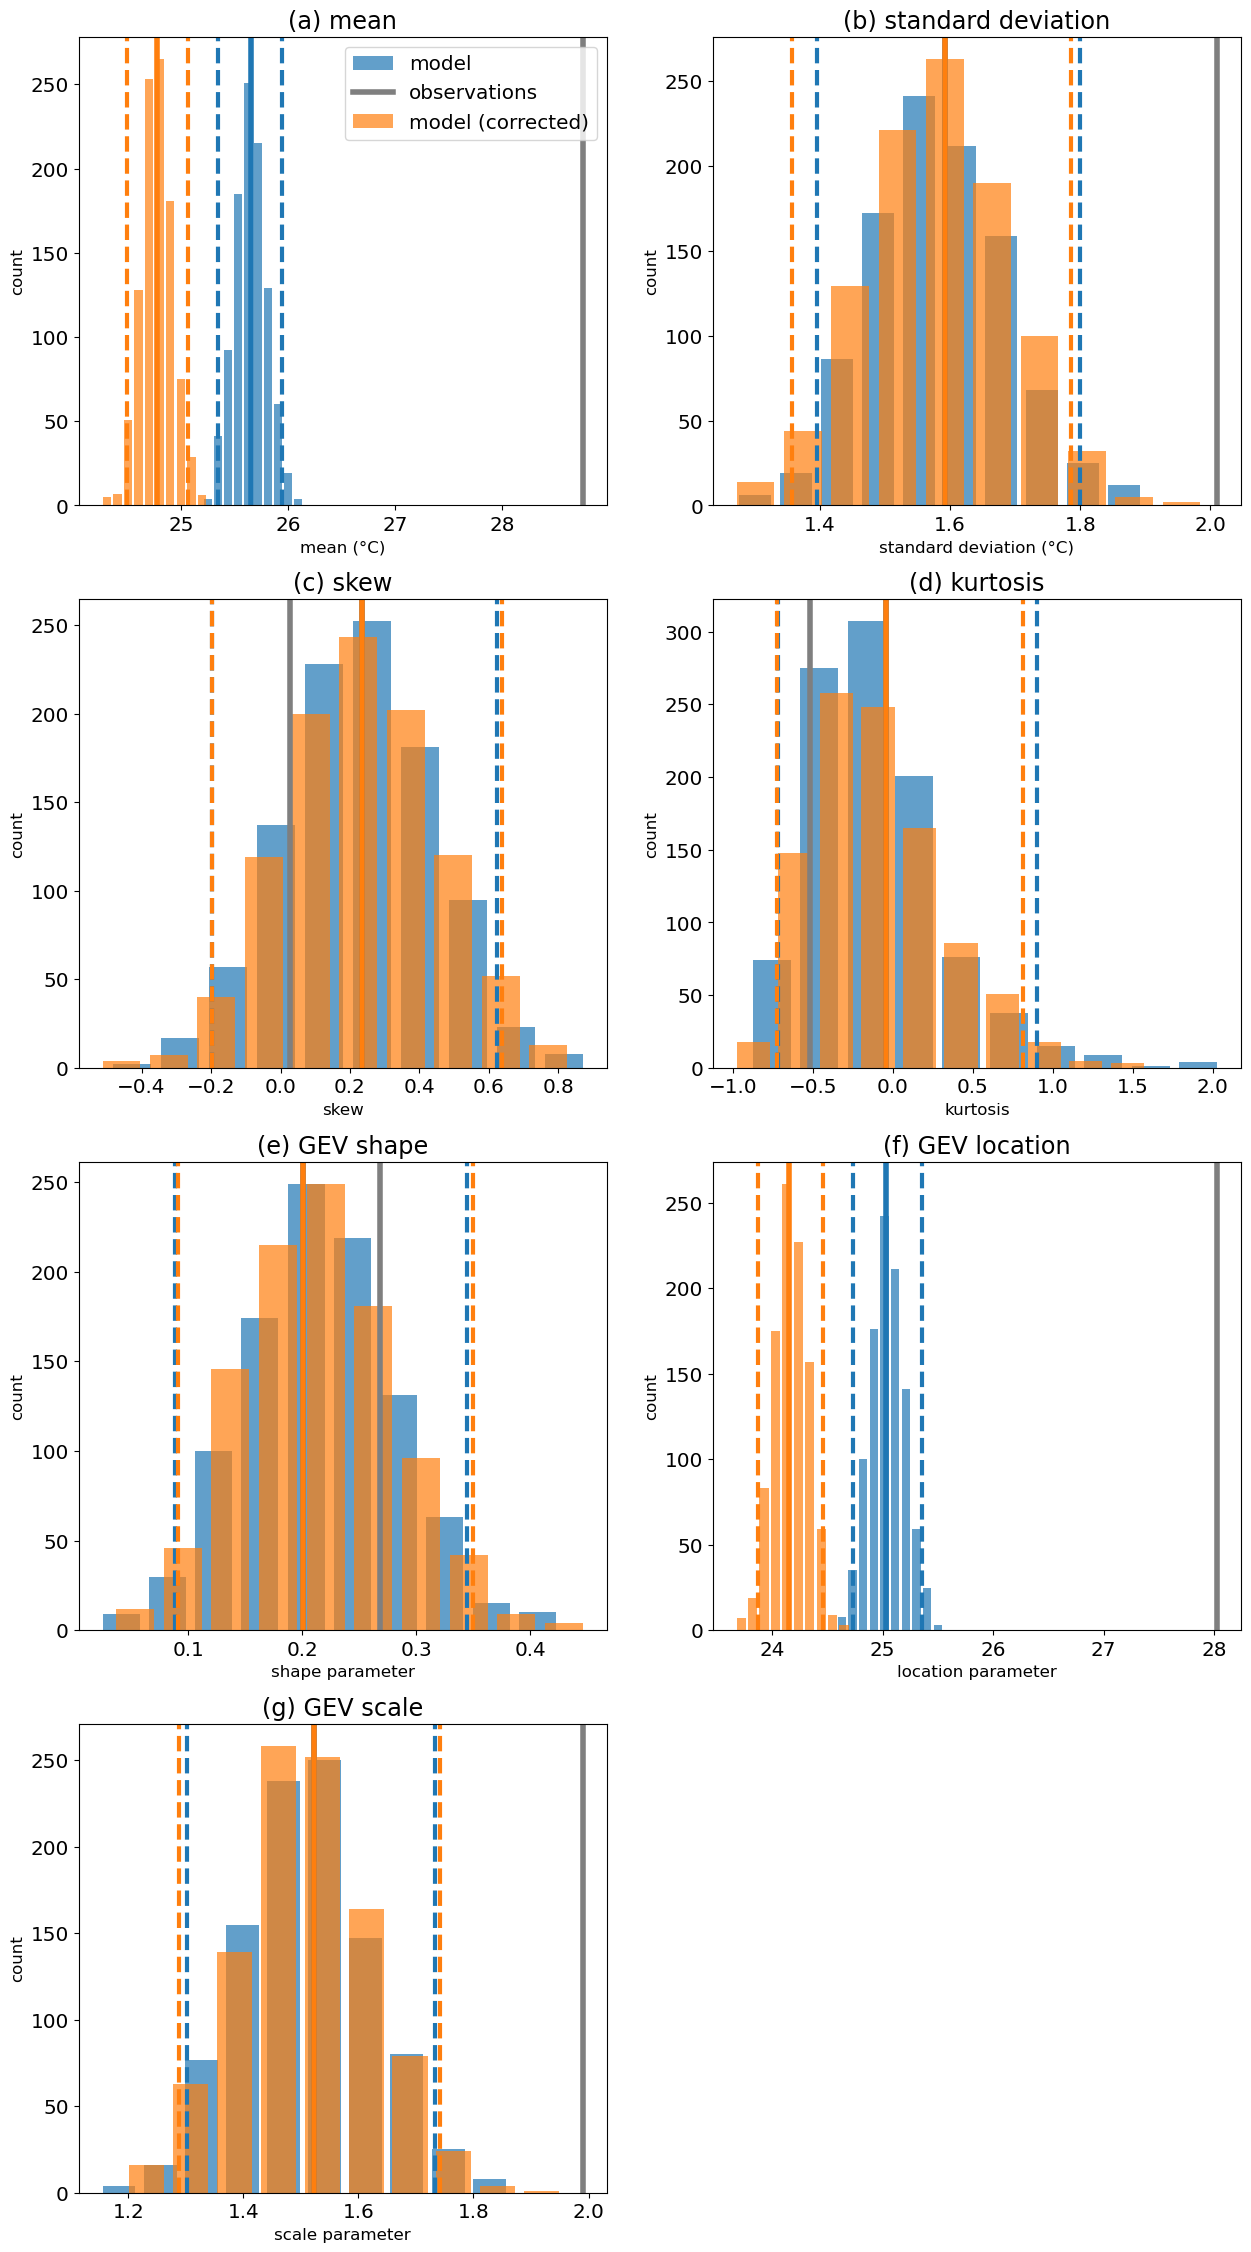

In [89]:
fidelity_tests(da_model_detrended_bc_mean_mulc)

### Additive - quantile correction

KS score: 0.28474012
KS p-value: 1.5740925e-08
AD score: 50.69888
AD p-value: 0.001


INFO:root:mean: Obs = 28.752838134765575, Model 95% CI =25.36920332137541 to 25.937389946363957
INFO:root:standard deviation: Obs = 2.010321314529908, Model 95% CI =1.38484854866204 to 1.7840441870585462
INFO:root:skew: Obs = 0.026002267969428786, Model 95% CI =-0.19978564565836796 to 0.6418202978756272
INFO:root:kurtosis: Obs = -0.5198032676375743, Model 95% CI =-0.7327208643242917 to 0.8732769026429422
INFO:root:GEV shape: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(0.26822544)
Coordinates:
    lat      float64 8B -41.5
    lon      float64 8B 145.0
    dparams  <U5 20B 'c'
Attributes:
    long_name:    Genextreme parameters
    description:  Parameters of the genextreme distribution
    method:       MLE
    estimator:    LMM
    scipy_dist:   genextreme
    units:        , Model 95% CI =0.08621940689593731 to 0.3511039380127288
INFO:root:GEV location: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(28.0275991)
Coordinates:
    lat      float64 8B -41.5
    lon      floa

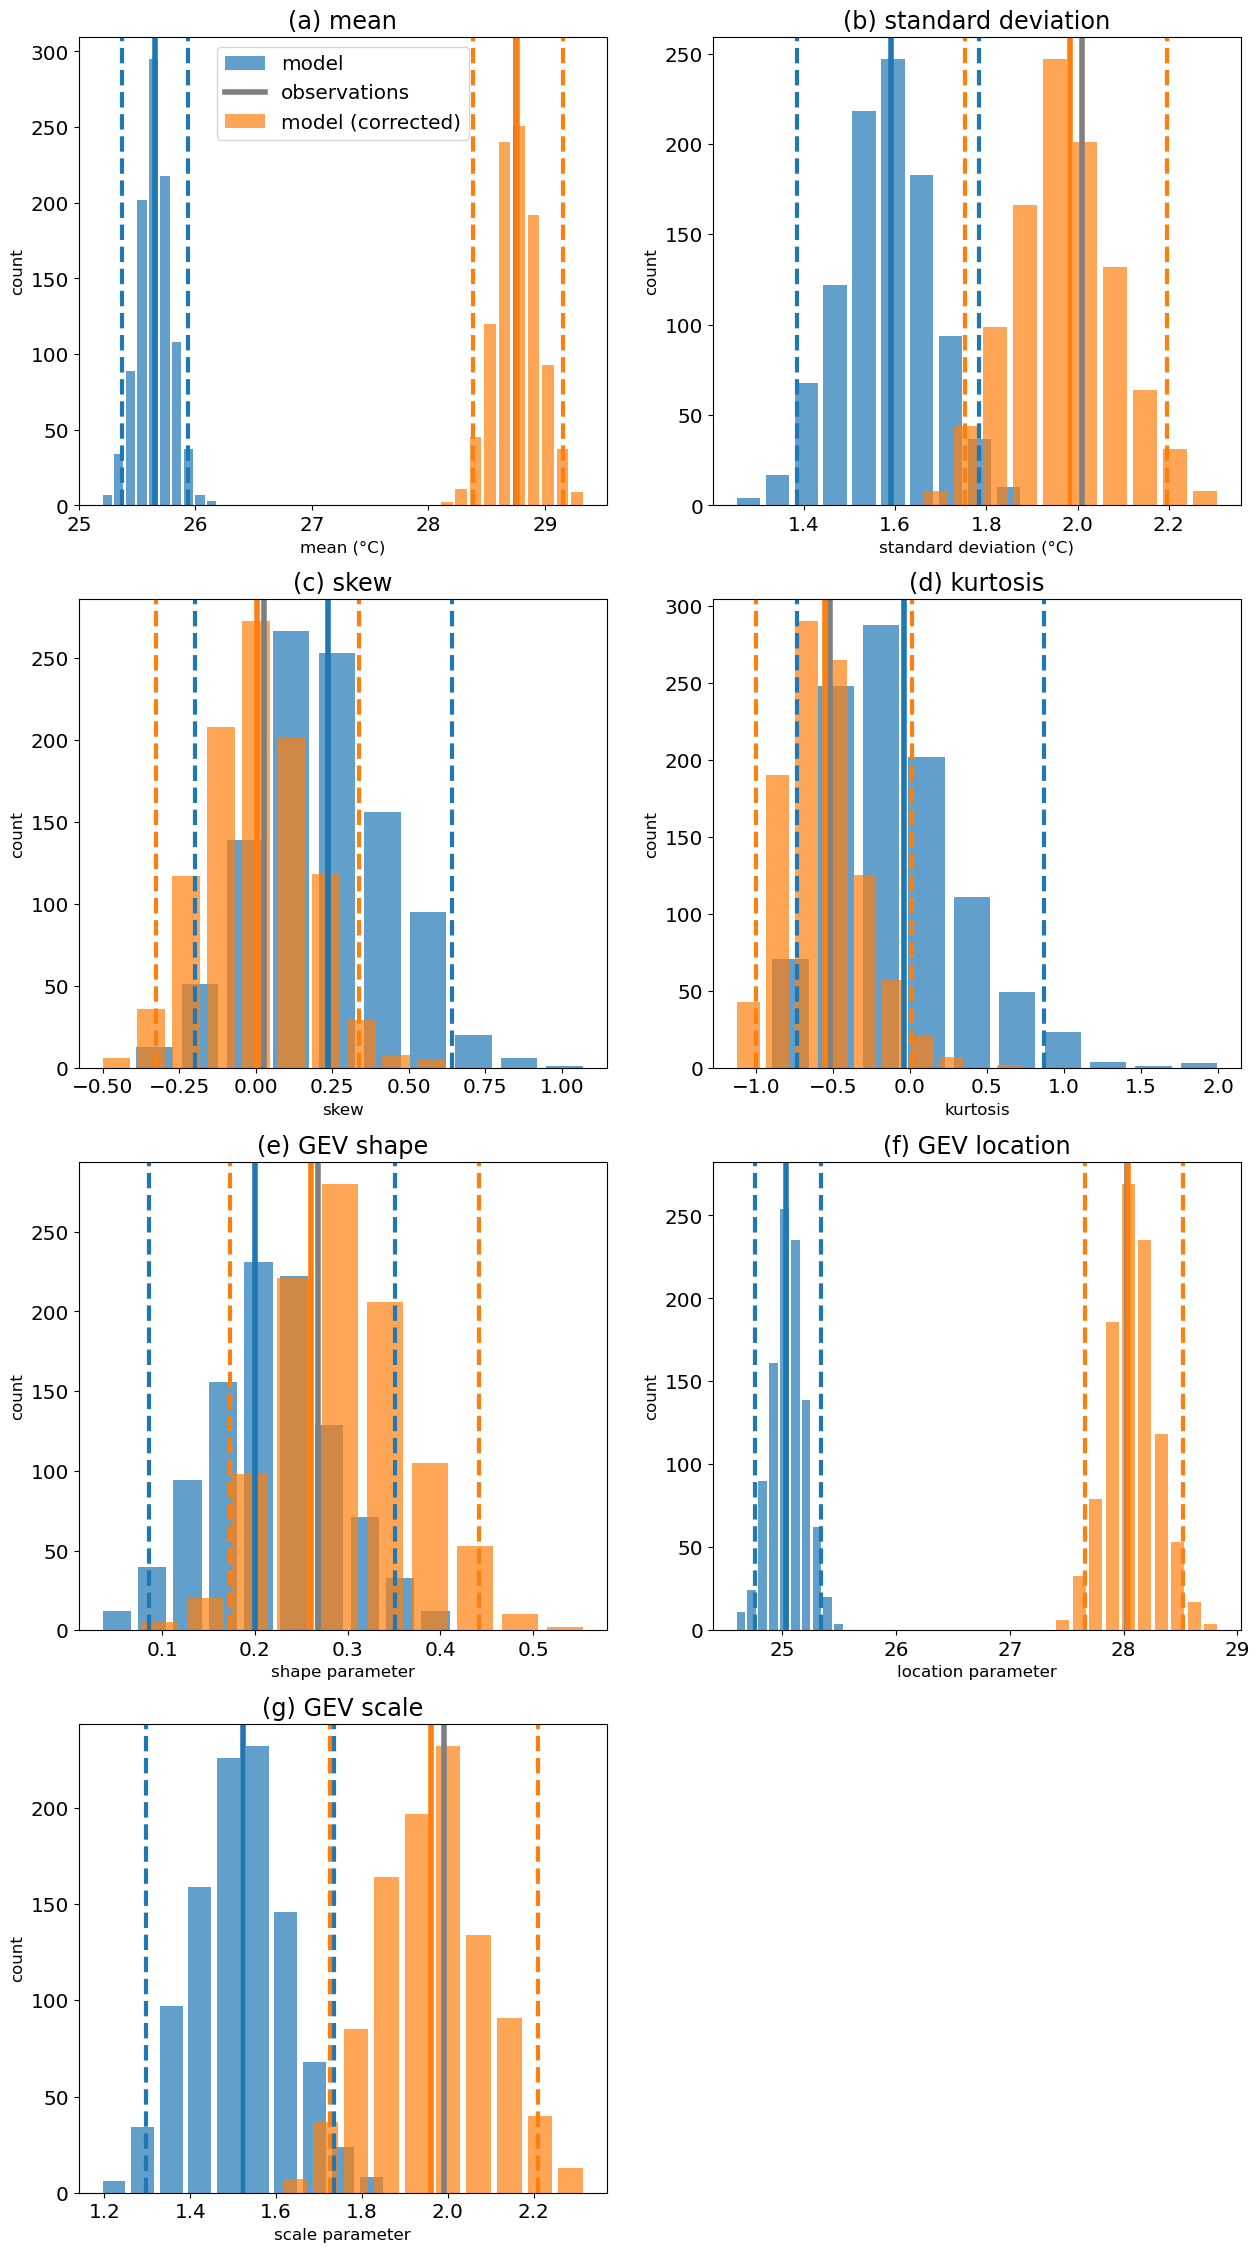

In [90]:
fidelity_tests(da_model_detrended_bc_quantile_add.unstack())

### Multiplicative - quantile correction

KS score: 0.28581226
KS p-value: 1.3646282e-08
AD score: 49.613907
AD p-value: 0.001


INFO:root:mean: Obs = 28.752838134765575, Model 95% CI =25.375128543729883 to 25.938427215766065
INFO:root:standard deviation: Obs = 2.010321314529908, Model 95% CI =1.387250135693921 to 1.7780926803573216
INFO:root:skew: Obs = 0.026002267969428786, Model 95% CI =-0.17023868092514655 to 0.6221214234284228
INFO:root:kurtosis: Obs = -0.5198032676375743, Model 95% CI =-0.7396558874821999 to 0.9142907725294787
INFO:root:GEV shape: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(0.26822544)
Coordinates:
    lat      float64 8B -41.5
    lon      float64 8B 145.0
    dparams  <U5 20B 'c'
Attributes:
    long_name:    Genextreme parameters
    description:  Parameters of the genextreme distribution
    method:       MLE
    estimator:    LMM
    scipy_dist:   genextreme
    units:        , Model 95% CI =0.10299192333031955 to 0.3478497671058276
INFO:root:GEV location: Obs = <xarray.DataArray 'tasmax' ()> Size: 8B
array(28.0275991)
Coordinates:
    lat      float64 8B -41.5
    lon      fl

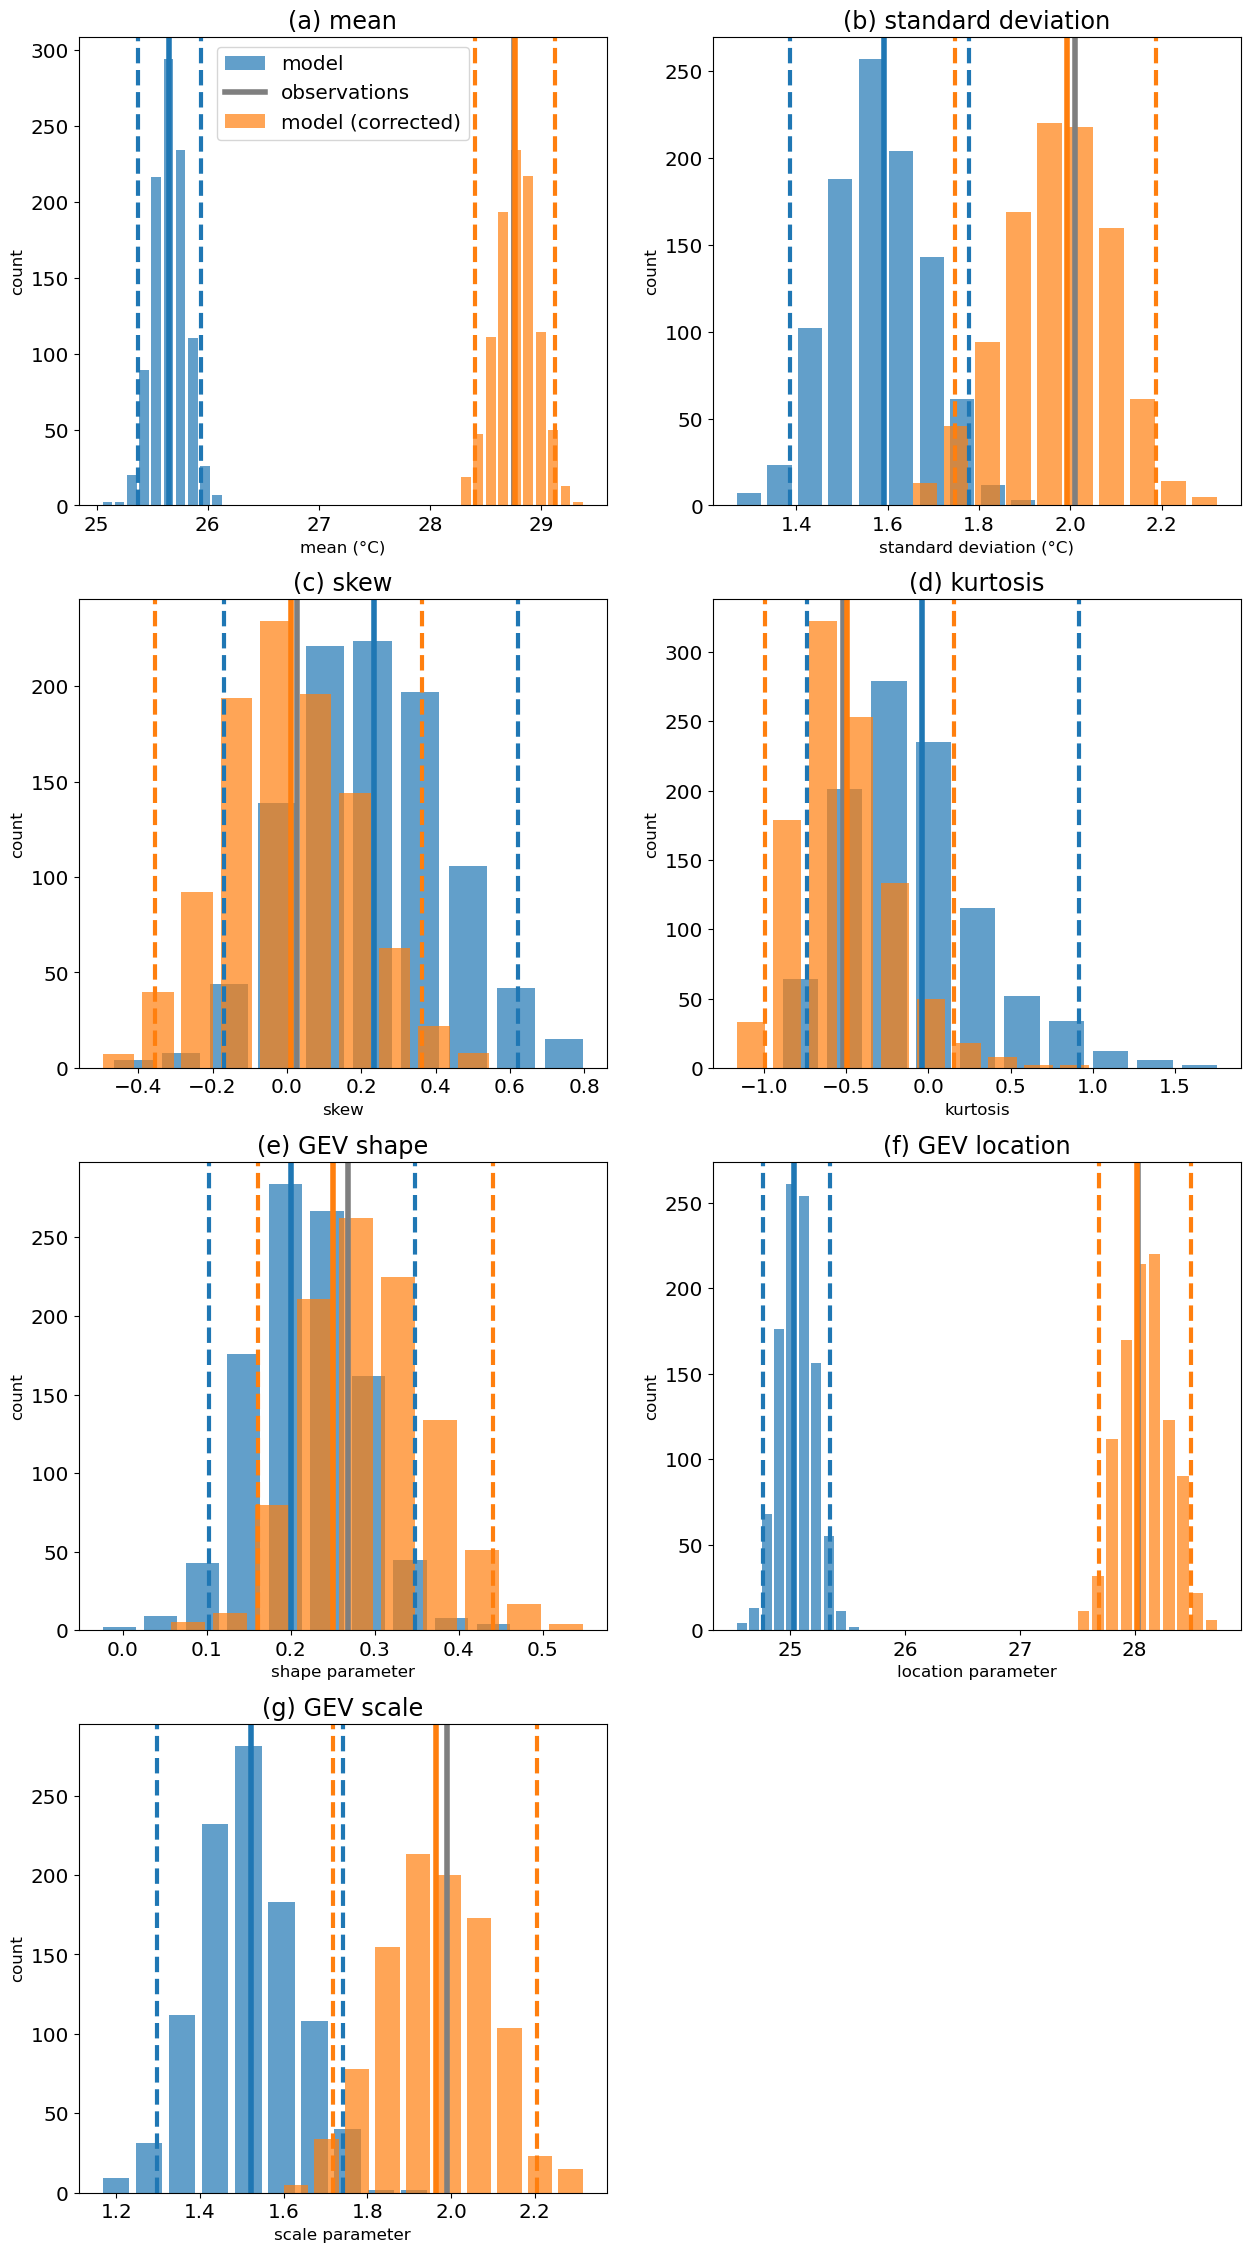

In [91]:
fidelity_tests(da_model_detrended_bc_quantile_mulc.unstack())